# Purpose

The purpose of this notebook is to investigate the use of the `censusdata` package.  The goal is to pull basic demographic and financial data per geographic entity (preferably census block) in a tabular format, with the intent to join this data to address level information.

For starters, I'm working from [this](https://towardsdatascience.com/accessing-census-data-with-python-3e2f2b56e20d) article on the basics of the [`censusdata`](https://pypi.org/project/CensusData/) package.

# Datasets

There are 5 datasets available through the package:

* ACS 1-year estimates (2012–2019) For areas with populations 65,000+, most frequently updated but with the lowest “resolution” since it excludes areas with low population and has the smallest sample size
* ACS 1-year supplemental estimates (2014–2019) Supplemental dataset that focuses on lower population areas of 20,000+
* ACS 3-year estimates (2010–2012 to 2011–2013) For areas with populations 20,000+, very much the middle ground between the 1 and 5 years. Currently discounted by the Census Bureau but old versions can still be accessed.
* ACS 5-year estimates (2005–2009 to 2015–2019) Data for all areas, highest resolution and largest sample size but the least current
* Census 2010 Summary File 1 Counts every resident of the US, updated every 10 years.

Much of the data I'm interested in is from the Nashville metro area, which is rapidly changing every year, especially in wealth and finances so data from the 2010 census will be very much out of date, despite being the highest resolution option.  At the time of writing this, only a limited amount of census 2020 data is available according to the census website, so that's not an option either.  Due to these reasons, it makes the most sense to go with ACS 5-year estimates for 2019.  This is the most current data that will give me granularity down to the census tract (for Data Profile tables) or block group (for detailed tables).

# Tables and Variables

The main difficulty when working with this data is going to be identifying exactly which variables to pull from which tables.  You can use the [census website](https://data.census.gov/cedsci/) to get an idea of which table you're looking for but I don't find it very intuitive as it seems the full list of variables is not availabe via the web interface.  It seems the most effective workflow is some combination of the following:

1. Find table(s) of interest
    * Find a table via the census website that you're interested in investigating and then print that table in python via the API to inspect variables.  
    * Alternatively, you can use the API to search for variables names, then inspect which tables those variables are associated with before choosing a table to investigate. This is the method suggested by the documentation of the package, though I find it pretty cumbersome.
2. Pull and print the table to identify which variables you need.
3. Use the API to choose geographies of interest.
4. Query the table for chosen variables and geographies.
5. Rename coded variables, split or aggregate geographies, and export.

Below, I'll search for variables containing 'income' in the *concept* which is the variable description.  Then, I'll choose a relevant table from the results.

In [1]:
import pandas as pd
import censusdata

vars = censusdata.search('acs5', 2019, 'concept', 'median income')
print(len(vars))

47


47 possible variables are returned from the search.  With such a small list, it's easy to print them out and investigate, though I've found it's pretty easy to return thousands of possible variables if you're search terms are not specific enough, e.g. when searching 'age'.

In [2]:
vars[0:45]

[('B06011PR_001E',
  'MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) BY PLACE OF BIRTH IN PUERTO RICO',
  'Estimate!!Median income in the past 12 months --!!Total:'),
 ('B06011PR_002E',
  'MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) BY PLACE OF BIRTH IN PUERTO RICO',
  'Estimate!!Median income in the past 12 months --!!Total:!!Born in Puerto Rico'),
 ('B06011PR_003E',
  'MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) BY PLACE OF BIRTH IN PUERTO RICO',
  'Estimate!!Median income in the past 12 months --!!Total:!!Born in other state of the United States'),
 ('B06011PR_004E',
  'MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) BY PLACE OF BIRTH IN PUERTO RICO',
  'Estimate!!Median income in the past 12 months --!!Total:!!Native; born elsewhere'),
 ('B06011PR_005E',
  'MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) BY PLACE OF BIRTH IN PUERTO RICO',
  'Estimate

Some of these look promising but none seem quite like what I want, which is just simply the household median income.  

After doing some investigation on the website, it seems like most of the straightforward demographic, social, economic, and housing information for the ACS 5 year estimates are summarized in the *Data Profile* (DP) series of tables: DP02, DP03, DP04, DP05.  It looks like DP03 has what I need in terms of median income ([link to website](https://data.census.gov/cedsci/table?q=United%20States&y=2019&d=ACS%205-Year%20Estimates%20Data%20Profiles&tid=ACSDP5Y2019.DP03)).

In [3]:
censusdata.printtable(censusdata.censustable('acs5', 2019, 'DP03'))

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
DP03_0001E   | SELECTED ECONOMIC CHARACTERIST | !! !! Estimate EMPLOYMENT STATUS Population 16 years and | int  
DP03_0001PE  | SELECTED ECONOMIC CHARACTERIST | !! !! Percent EMPLOYMENT STATUS Population 16 years and  | int  
DP03_0002E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! Estimate EMPLOYMENT STATUS Population 16 years  | int  
DP03_0002PE  | SELECTED ECONOMIC CHARACTERIST | !! !! !! Percent EMPLOYMENT STATUS Population 16 years a | float
DP03_0003E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! Estimate EMPLOYMENT STATUS Population 16 yea | int  
DP03_0003PE  | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! Percent EMPLOYMENT STATUS Population 16 year | float
DP03_0004E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! !! Estimate EMPLOYMENT STATUS Pop

You can open the printout above in a text editor to see more detail, but I still find it pretty cumbersome to navigate.  The full list of variables for DP tables can also be found on the census website [here](https://api.census.gov/data/2019/acs/acs5/profile/variables.html).  I find this quite a bit easier to work with.  

By searching through these docs I found household income by bins (DP03_0052E - DP03_0061E), median household income (DP03_0062E), and mean household income (DP03_0063E).  I'm also going to pull total households (DP03_0051E) to use as a denominator.

# Geographies

In order to query using the API you'll need to supply the relevant geography codes, which aren't very intuitive.  The API provides a handy way to find and compile the codes through the use of `geographies` and `censusgeo`.  Below, I'm finding the code for Davidson County in TN, which I'm going to use to query all block groups contained within.  If you need a primer on how the census geography heirarchy works, there's a pretty handy figure located [here](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf).

In [4]:
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2019)
states['Tennessee']

censusgeo((('state', '47'),))

In [5]:
counties = censusdata.geographies(censusdata.censusgeo([('state', '47'), ('county', '*')]), 'acs5', 2019)
counties

{'Sumner County, Tennessee': censusgeo((('state', '47'), ('county', '165'))),
 'Trousdale County, Tennessee': censusgeo((('state', '47'), ('county', '169'))),
 'Clay County, Tennessee': censusgeo((('state', '47'), ('county', '027'))),
 'Shelby County, Tennessee': censusgeo((('state', '47'), ('county', '157'))),
 'Henderson County, Tennessee': censusgeo((('state', '47'), ('county', '077'))),
 'Jefferson County, Tennessee': censusgeo((('state', '47'), ('county', '089'))),
 'Sequatchie County, Tennessee': censusgeo((('state', '47'), ('county', '153'))),
 'Carroll County, Tennessee': censusgeo((('state', '47'), ('county', '017'))),
 'Davidson County, Tennessee': censusgeo((('state', '47'), ('county', '037'))),
 'Perry County, Tennessee': censusgeo((('state', '47'), ('county', '135'))),
 'Meigs County, Tennessee': censusgeo((('state', '47'), ('county', '121'))),
 'Haywood County, Tennessee': censusgeo((('state', '47'), ('county', '075'))),
 'Montgomery County, Tennessee': censusgeo((('state

In [6]:
tracts = censusdata.geographies(censusdata.censusgeo([('state', '47'), ('county', '037'), ('tract', '*')]), 'acs5', 2019)
block_groups = censusdata.geographies(censusdata.censusgeo([('state', '47'), ('county', '037'), ('block group', '*')]), 'acs5', 2019)
print(f'''
    Total census tracts in Davidson County: {len(tracts)}
    Total block groups in Davidson County: {len(block_groups)}
''')


    Total census tracts in Davidson County: 161
    Total block groups in Davidson County: 473



# Query Table

Now I can finally query the table for my desired variables and geographies.  I'm also going to manually rename the variables with some human readable names.  This could probably be handled more programmatically using the xml or json from the [variables list on data.census.gov](https://api.census.gov/data/2019/acs/acs5/profile/variables.html), but most of the labels are pretty verbose so I'll handle it manually for now.

In [7]:
data = censusdata.download(
    'acs5', 2015,
    censusdata.censusgeo([
        ('state', '47'),
        ('county', '037'),
        ('tract', '*')
    ]),
    ['DP03_0051E',
    'DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E', 'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP03_0060E', 'DP03_0061E',
    'DP03_0062E', 'DP03_0063E'],
    tabletype='profile'
)

data.reset_index(inplace=True)
data.columns = [
    'geo_raw',
    'total_households',
    'less_than_10K', '10K_to_15K', '15K_to_25K', '25K_to_35K', '35K_to_50K', '50K_to_75K', '75K_to_100K', '100K_to_150K', '150K_to_200K', 'more_than_200K',
    'median_income', 'mean_income'
]

In [8]:
data.sample(5)

,geo_raw,total_households,less_than_10K,10K_to_15K,15K_to_25K,25K_to_35K,35K_to_50K,50K_to_75K,75K_to_100K,100K_to_150K,150K_to_200K,more_than_200K,median_income,mean_income
33,"Census Tract 173, Davidson County, Tennessee: ...",1172,107,28,244,248,186,286,15,48,0,10,32033,47767
104,"Census Tract 108.01, Davidson County, Tennesse...",2285,206,212,225,444,536,370,233,49,6,4,39250,41405
103,"Census Tract 191.11, Davidson County, Tennesse...",1848,128,61,160,301,483,370,141,138,41,25,43836,54587
11,"Census Tract 139, Davidson County, Tennessee: ...",679,138,86,165,160,74,38,10,4,0,4,21884,25687
92,"Census Tract 191.09, Davidson County, Tennesse...",1674,83,99,175,289,268,442,212,89,17,0,43821,49453


# Split Geography

Now that I have a table I'm happy with, I'm going to split the geography into columns for easier joining later.  The elements contained in `geo_raw` are currently of type `censusdata.censusgeo.censusgeo`.  The `params()` method of this class lets you pull each parameter out as a tuple, so with a little knowledge of the heirarchy which was applied during the query step, these can be pulled out individually.

In [9]:
def extract_geo(geo_raw, level):
    tup = geo_raw.params()
    return tup[level][1]

data['state'] = data['geo_raw'].apply(extract_geo, args=(0,))
data['county'] = data['geo_raw'].apply(extract_geo, args=(1,))
data['tract'] = data['geo_raw'].apply(extract_geo, args=(2,))

data.drop('geo_raw', axis=1, inplace=True)

In [10]:
data.sample(5)

,total_households,less_than_10K,10K_to_15K,15K_to_25K,25K_to_35K,35K_to_50K,50K_to_75K,75K_to_100K,100K_to_150K,150K_to_200K,more_than_200K,median_income,mean_income,state,county,tract
46,1265,100,36,158,183,365,240,75,61,30,17,40137,50978,47,037,018905
97,1818,104,112,212,137,309,459,230,171,52,32,50774,60270,47,037,015100
28,4865,61,84,246,227,526,1201,873,1028,385,234,78488,91536,47,037,019114
110,2702,64,168,441,272,462,606,491,153,36,9,46270,52535,47,037,015620
148,1293,44,33,160,133,169,264,161,301,9,19,62929,68421,47,037,010104


# Join with Polygon Data

For extra credit, I'm going to join with the polygon data for census tracts and make a couple quick maps.  The polygon shape files are available on the [census website](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html) and you can pull the shapefiles directly into python using `geopandas`. 

In [11]:
import geopandas as gpd

url = 'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_47_tract.zip'
tn_tract = gpd.read_file(url)

#reproject to TN state plane for plotting ease
tn_tract = tn_tract.to_crs(epsg = 2274)

print(f'''
Shape of shape file: {tn_tract.shape}
CRS of shape file: {tn_tract.crs}
''')


Shape of shape file: (1497, 13)
CRS of shape file: epsg:2274



In [12]:
tn_tract.sample(5)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
697,47,053,967100,47053967100,9671,Census Tract 9671,G5020,S,64863518,137578,+35.8218707,-088.7760946,"POLYGON ((1129281.306 562236.206, 1129354.710 ..."
662,47,089,070700,47089070700,707,Census Tract 707,G5020,S,69622547,13451918,+36.0333582,-083.4052231,"POLYGON ((2713183.157 624140.069, 2713203.700 ..."
1127,47,157,021111,47157021111,211.11,Census Tract 211.11,G5020,S,6818544,0,+35.1780204,-089.8525473,"POLYGON ((808306.744 323518.140, 808351.305 32..."
586,47,047,060501,47047060501,605.01,Census Tract 605.01,G5020,S,114732402,440505,+35.2371087,-089.4238334,"POLYGON ((922297.663 368351.753, 922329.072 36..."
1486,47,165,020700,47165020700,207,Census Tract 207,G5020,S,7878585,0,+36.3948656,-086.4255873,"POLYGON ((1834783.741 746859.102, 1834869.407 ..."


Now I'm going to cut down to only the census tracts contained in Davidson County.

In [13]:
davidson_tract = tn_tract[tn_tract['COUNTYFP']=='037']

In [14]:
data_geo = davidson_tract.merge(data, how='inner', left_on='TRACTCE', right_on='tract')
data_geo = data_geo[data_geo['total_households'] > 0]

And now defining some income bins of interest and mapping using `matplotlib`.

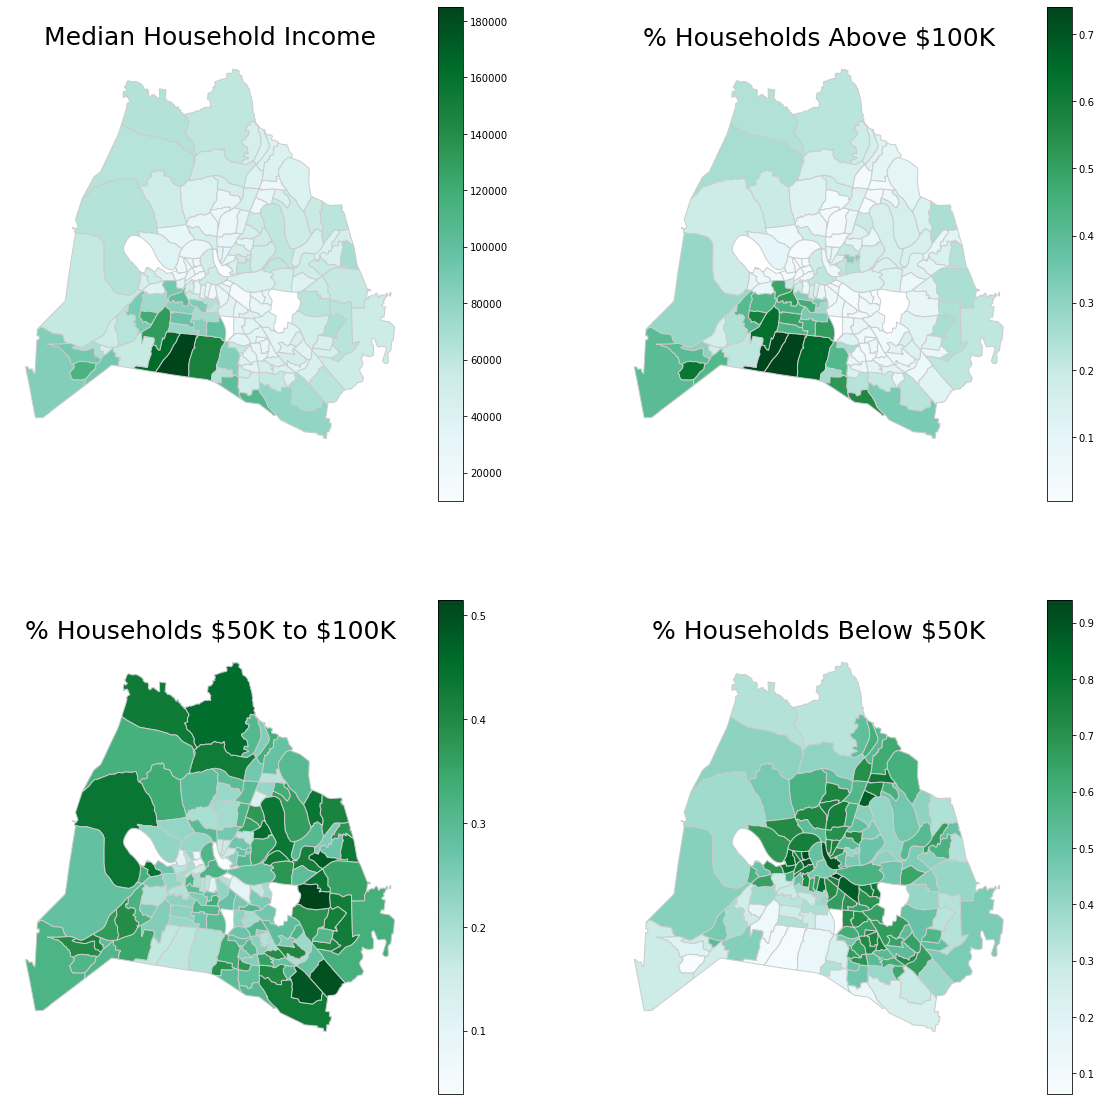

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20,20))

def plot_geo(col, ax, title):
    data_geo.plot(
        column = col,
        ax = ax,
        cmap = "BuGn",
        edgecolor = '0.8',
        legend = True
    )
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

data_geo['pct_more_than_100K'] = (data_geo['more_than_200K'] + data_geo['150K_to_200K'] + data_geo['100K_to_150K']) / data_geo['total_households']
data_geo['pct_50K_to_100K'] = (data_geo['50K_to_75K'] + data_geo['75K_to_100K']) / data_geo['total_households']
data_geo['pct_less_than_50K'] = (data_geo['less_than_10K'] + data_geo['10K_to_15K'] + data_geo['15K_to_25K'] + data_geo['25K_to_35K'] + data_geo['35K_to_50K']) / data_geo['total_households']

plot_geo('median_income', ax[0,0], 'Median Household Income')
plot_geo('pct_more_than_100K', ax[0,1], '% Households Above $100K')
plot_geo('pct_50K_to_100K', ax[1,0], '% Households \$50K to $100K')
plot_geo('pct_less_than_50K', ax[1,1], '% Households Below $50K')

plt.show()